In [ ]:
!pip install --upgrade numpy gensim

  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)


In [ ]:
!pip install fasttext

In [ ]:
!pip install tensorflow

In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
import joblib
import fasttext
import gensim
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.models import load_model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Bidirectional, GRU
from tensorflow.keras.optimizers import Adam

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### SECTION 1: Load data

In [ ]:
uploaded = files.upload()

Saving Extended_NLP_Project_dataset (2).csv to Extended_NLP_Project_dataset (2).csv


In [ ]:
data = pd.read_csv('Extended_NLP_Project_dataset (2).csv')

In [ ]:
print("Dataset overview:")
print(data.info())

Dataset overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Disease      1200 non-null   object
 1   Description  1200 non-null   object
dtypes: object(2)
memory usage: 18.9+ KB
None


In [ ]:
print(data.tail(7))

                      Disease  \
1193  Urinary Tract Infection   
1194  Urinary Tract Infection   
1195  Urinary Tract Infection   
1196  Urinary Tract Infection   
1197  Urinary Tract Infection   
1198  Urinary Tract Infection   
1199  Urinary Tract Infection   

                                            Description  
1193  I have noticed persistent burning sensation wh...  
1194  Lately, I have been experiencing symptoms such...  
1195  Lately, I have been experiencing symptoms such...  
1196  For the past few days, I have been suffering f...  
1197  Lately, I have been experiencing symptoms such...  
1198  For the past few days, I have been suffering f...  
1199  For the past few days, I have been suffering f...  


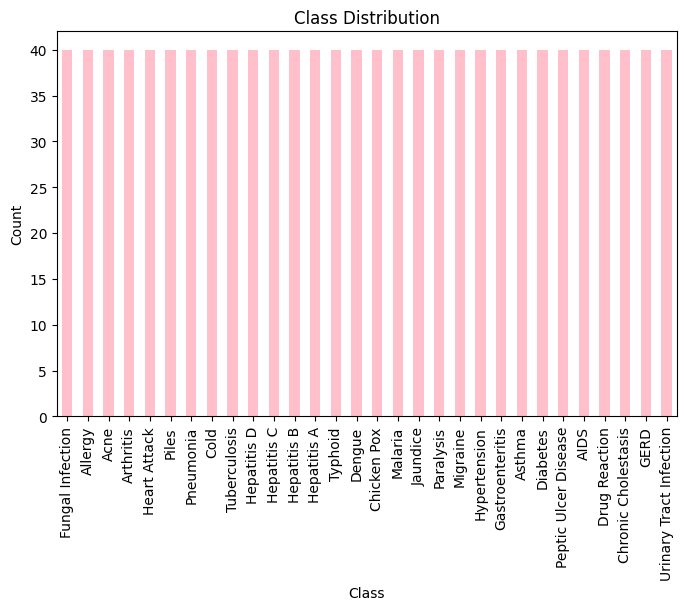

In [ ]:
plt.figure(figsize=(8, 5))
data['Disease'].value_counts().plot(kind='bar', color='pink')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

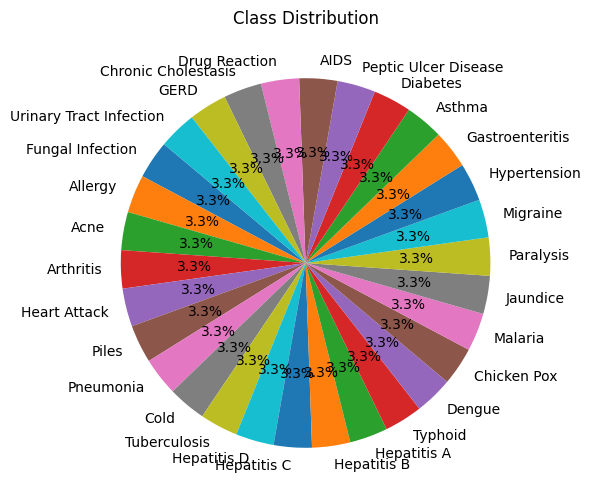

In [ ]:
class_distribution = data['Disease'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(class_distribution, labels=class_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title("Class Distribution")
plt.show()


Text Length Statistics:
count    1200.000000
mean      339.116667
std        15.567649
min       298.000000
25%       328.000000
50%       338.000000
75%       350.000000
max       390.000000
Name: Description, dtype: float64


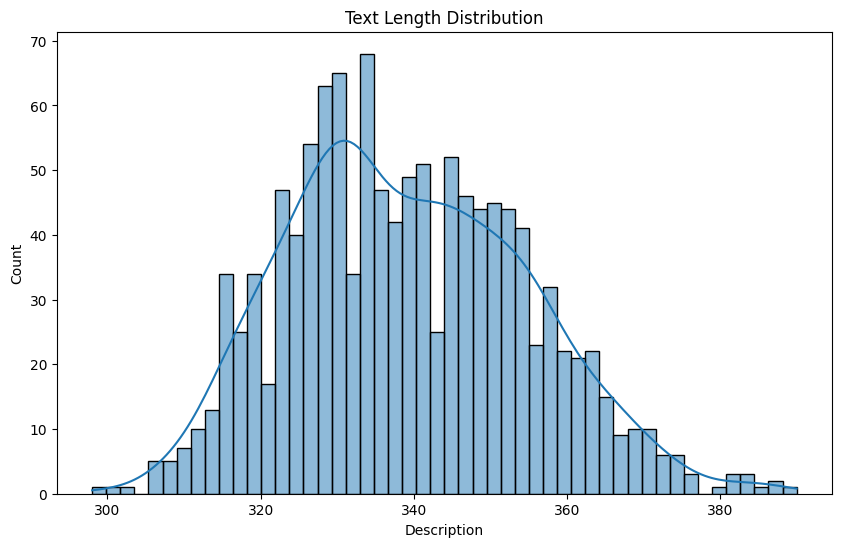

In [ ]:
data['Description'] = data['Description'].astype(str)
data['Description'] = data['Description'].apply(len)
print("\nText Length Statistics:")
print(data['Description'].describe())
plt.figure(figsize=(10, 6))
sns.histplot(data['Description'], bins=50, kde=True)
plt.title("Text Length Distribution")
plt.show()

In [ ]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)
print("Data split completed.")
print(f"Train set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Data split completed.
Train set size: 864
Validation set size: 96
Test set size: 240


### SECTION 2: TEXT PROCESSING

In [ ]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text, use_stemming=False, use_lemmatization=False):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]

    if use_stemming:
        tokens = [stemmer.stem(word) for word in tokens]
    elif use_lemmatization:
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

train_data['Description_processed'] = train_data['Description'].apply(preprocess_text, use_lemmatization=True)
val_data['Description_processed'] = val_data['Description'].apply(preprocess_text, use_lemmatization=True)
test_data['Description_processed'] = test_data['Description'].apply(preprocess_text, use_lemmatization=True)
print(train_data[['Description', 'Description_processed']].head())

                                         Description  \
0  Lately, I have been experiencing symptoms such...   
1  I have noticed persistent painful blisters, pe...   
2  I have noticed persistent itchy patches, redne...   
3  I have noticed persistent itchy patches, redne...   
4  Lately, I have been experiencing symptoms such...   

                               Description_processed  
0  lately experiencing symptom itchy patch rednes...  
1  noticed persistent painful blister peeling ski...  
2  noticed persistent itchy patch redness scaling...  
3  noticed persistent itchy patch redness scaling...  
4  lately experiencing symptom painful blister pe...  


### SECTION 3: Text Embedding

In [ ]:
label_encoder = LabelEncoder()
train_data['Disease'] = label_encoder.fit_transform(train_data['Disease'])
val_data['Disease'] = label_encoder.transform(val_data['Disease'])
test_data['Disease'] = label_encoder.transform(test_data['Disease'])

In [ ]:
# Bag of Words (BoW)
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(train_data['Description_processed']).toarray()
X_val_bow = bow_vectorizer.transform(val_data['Description_processed']).toarray()
X_test_bow = bow_vectorizer.transform(test_data['Description_processed']).toarray()

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['Description_processed']).toarray()
X_val_tfidf = tfidf_vectorizer.transform(val_data['Description_processed']).toarray()
X_test_tfidf = tfidf_vectorizer.transform(test_data['Description_processed']).toarray()

# Convert text into tokenized lists
train_tokens = train_data['Description_processed'].apply(word_tokenize)
val_tokens = val_data['Description_processed'].apply(word_tokenize)
test_tokens = test_data['Description_processed'].apply(word_tokenize)

# FastText (Word Embeddings)
fasttext_model = gensim.models.FastText(sentences=train_tokens, vector_size=100, window=5, min_count=5)
X_train_fasttext = np.array([np.mean([fasttext_model.wv[word] for word in text if word in fasttext_model.wv] or [np.zeros(100)], axis=0) for text in train_tokens])
X_val_fasttext = np.array([np.mean([fasttext_model.wv[word] for word in text if word in fasttext_model.wv] or [np.zeros(100)], axis=0) for text in val_tokens])
X_test_fasttext = np.array([np.mean([fasttext_model.wv[word] for word in text if word in fasttext_model.wv] or [np.zeros(100)], axis=0) for text in test_tokens])

# Word2Vec (Word Embeddings)
word2vec_model = gensim.models.Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=5)
X_train_word2vec = np.array([np.mean([word2vec_model.wv[word] for word in text if word in word2vec_model.wv] or [np.zeros(100)], axis=0) for text in train_tokens])
X_val_word2vec = np.array([np.mean([word2vec_model.wv[word] for word in text if word in word2vec_model.wv] or [np.zeros(100)], axis=0) for text in val_tokens])
X_test_word2vec = np.array([np.mean([word2vec_model.wv[word] for word in text if word in word2vec_model.wv] or [np.zeros(100)], axis=0) for text in test_tokens])

print("Embedding completed for BoW, TF-IDF, FastText, and Word2Vec.")

Embedding completed for BoW, TF-IDF, FastText, and Word2Vec.


In [ ]:
joblib.dump(tfidf_vectorizer, "tfidf_vectorizer.pkl")

joblib.dump(bow_vectorizer, "bow_vectorizer.pkl")

word2vec_model.save("word2vec_model.model")

joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

### SECTION 4: Model Training with Different Architectures

In [ ]:
y_train = train_data['Disease']
y_val = val_data['Disease']
y_test = test_data['Disease']

def cnn_model(input_dim, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=5000))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))  # Output layer for multi-class
    model.compile(optimizer= Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def lstm_model(input_dim, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=5000))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='softmax'))  # Output layer for multi-class
    model.compile(optimizer= Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def cnn_bilstm_model(input_dim, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=5000))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(num_classes, activation='softmax'))  # Output layer for multi-class
    model.compile(optimizer= Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def gru_model(input_dim, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=5000))
    model.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def cnn_gru_model(input_dim, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=5000))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def bilstm_gru_model(input_dim, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=5000))
    model.add(Bidirectional(LSTM(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
    model.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

input_dim = 5000
num_classes = 30

# CNN Model
cnn = cnn_model(input_dim, num_classes)
cnn.fit(X_train_bow, y_train, validation_data=(X_val_bow, y_val), epochs=5, batch_size=64)

# LSTM Model
lstm = lstm_model(input_dim, num_classes)
lstm.fit(X_train_bow, y_train, validation_data=(X_val_bow, y_val), epochs=5, batch_size=64)

# CNN-BiLSTM Model
cnn_bilstm = cnn_bilstm_model(input_dim, num_classes)
cnn_bilstm.fit(X_train_bow, y_train, validation_data=(X_val_bow, y_val), epochs=5, batch_size=64)

# GRU Model
gru = gru_model(input_dim, num_classes)
gru.fit(X_train_bow, y_train, validation_data=(X_val_bow, y_val), epochs=5, batch_size=64)

# CNN-GRU Model
cnn_gru = cnn_gru_model(input_dim, num_classes)
cnn_gru.fit(X_train_bow, y_train, validation_data=(X_val_bow, y_val), epochs=5, batch_size=64)

# BiLSTM-GRU Model
bilstm_gru = bilstm_gru_model(input_dim, num_classes)
bilstm_gru.fit(X_train_bow, y_train, validation_data=(X_val_bow, y_val), epochs=5, batch_size=64)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.0301 - loss: 3.5194 - val_accuracy: 0.0208 - val_loss: 3.5092
Epoch 2/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.0386 - loss: 3.4877 - val_accuracy: 0.0208 - val_loss: 3.4916
Epoch 3/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - accuracy: 0.0496 - loss: 3.4437 - val_accuracy: 0.0208 - val_loss: 3.4739
Epoch 4/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.0565 - loss: 3.3891 - val_accuracy: 0.0625 - val_loss: 3.4660
Epoch 5/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.1031 - loss: 3.3070 - val_accuracy: 0.0208 - val_loss: 3.4578
Epoch 1/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 527ms/step - accuracy: 0.0291 - loss: 3.5263 - val_accuracy: 0.0312 - val_loss: 3.5235
Epoch 2/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 495ms/step - accuracy: 0.0263 - loss: 3.5215 - val_accuracy: 0.0312 - val_loss: 3.5183
Epoch 3/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 509ms/step - accuracy: 0.0363 - loss: 3.5154 - val_accuracy: 0.0208 - val_loss: 

Training Models By Tf-IDF

In [ ]:
input_dim = 5000
num_classes = 30

# CNN Model
cnn = cnn_model(input_dim, num_classes)
cnn.fit(X_train_tfidf, y_train, validation_data=(X_val_tfidf, y_val), epochs=5, batch_size=64)

# LSTM Model
lstm = lstm_model(input_dim, num_classes)
lstm.fit(X_train_tfidf, y_train, validation_data=(X_val_tfidf, y_val), epochs=5, batch_size=64)


# CNN-BiLSTM Model
cnn_bilstm = cnn_bilstm_model(input_dim, num_classes)
cnn_bilstm.fit(X_train_tfidf, y_train, validation_data=(X_val_tfidf, y_val), epochs=5, batch_size=64)


# GRU Model
gru = gru_model(input_dim, num_classes)
gru.fit(X_train_tfidf, y_train, validation_data=(X_val_tfidf, y_val), epochs=5, batch_size=64)

# CNN-GRU Model
cnn_gru = cnn_gru_model(input_dim, num_classes)
cnn_gru.fit(X_train_tfidf, y_train, validation_data=(X_val_tfidf, y_val), epochs=5, batch_size=64)


# BiLSTM-GRU Model
bilstm_gru = bilstm_gru_model(input_dim, num_classes)
bilstm_gru.fit(X_train_tfidf, y_train, validation_data=(X_val_tfidf, y_val), epochs=5, batch_size=64)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.0324 - loss: 3.5216 - val_accuracy: 0.0312 - val_loss: 3.5076
Epoch 2/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.0328 - loss: 3.5001 - val_accuracy: 0.0312 - val_loss: 3.4885
Epoch 3/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.0447 - loss: 3.4727 - val_accuracy: 0.0104 - val_loss: 3.4848
Epoch 4/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.0282 - loss: 3.4653 - val_accuracy: 0.0208 - val_loss: 3.4804
Epoch 5/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.0260 - loss: 3.4642 - val_accuracy: 0.0208 - val_loss: 3.4771
Epoch 1/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 535ms/step - accuracy: 0.0255 - loss: 3.5237 - val_accuracy: 0.0312 - val_loss: 3.5173
Epoch 2/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 435ms/step - accuracy: 0.0286 - loss: 3.5191 - val_accuracy: 0.0417 - val_loss: 3.5119
Epoch 3/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 506ms/step - accuracy: 0.0441 - loss: 3.5111 - val_accuracy: 0.0417 - val_loss: 

Training Model By Fasttext


In [ ]:
input_dim = 5000
num_classes = 30

cnn = cnn_model(input_dim, num_classes)
cnn.fit(X_train_fasttext, y_train, validation_data=(X_val_fasttext, y_val), epochs=5, batch_size=64)

# LSTM Model
lstm = lstm_model(input_dim, num_classes)
lstm.fit(X_train_fasttext, y_train, validation_data=(X_val_fasttext, y_val), epochs=5, batch_size=64)

# CNN-BiLSTM Model
cnn_bilstm = cnn_bilstm_model(input_dim, num_classes)
cnn_bilstm.fit(X_train_fasttext, y_train, validation_data=(X_val_fasttext, y_val), epochs=5, batch_size=64)

# GRU Model
gru = gru_model(input_dim, num_classes)
gru.fit(X_train_fasttext, y_train, validation_data=(X_val_fasttext, y_val), epochs=5, batch_size=64)

# CNN-GRU Model
cnn_gru = cnn_gru_model(input_dim, num_classes)
cnn_gru.fit(X_train_fasttext, y_train, validation_data=(X_val_fasttext, y_val), epochs=5, batch_size=64)

# BiLSTM-GRU Model
bilstm_gru = bilstm_gru_model(input_dim, num_classes)
bilstm_gru.fit(X_train_fasttext, y_train, validation_data=(X_val_fasttext, y_val), epochs=5, batch_size=64)

Epoch 1/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.0400 - loss: 3.5253 - val_accuracy: 0.0625 - val_loss: 3.5119
Epoch 2/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.0333 - loss: 3.5163 - val_accuracy: 0.0625 - val_loss: 3.4980
Epoch 3/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.0273 - loss: 3.5065 - val_accuracy: 0.0625 - val_loss: 3.4746
Epoch 4/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.0413 - loss: 3.4883 - val_accuracy: 0.0625 - val_loss: 3.4532
Epoch 5/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.0295 - loss: 3.4849 - val_accuracy: 0.0625 - val_loss: 3.4387
Epoch 1/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 260ms/step - accuracy: 0.0381 - loss: 3.5273 - val_accuracy: 0.0833 - val_loss: 3.5180
Epoch 2/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 297ms/step - accuracy: 0.0336 - loss: 3.5195 - val_accuracy: 0.0208 - val_loss: 3.5111
Epoch 3/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 281ms/step - accuracy: 0.0287 - loss: 3.5141 - val_accuracy: 0.0000e+00 - v

### 5. Comparative Analysis of Models

In [ ]:
y_true = y_test

# Evaluate CNN model
y_pred_cnn = cnn.predict(X_test_bow)
y_pred_cnn = np.argmax(y_pred_cnn, axis=1)
cnn_acc = accuracy_score(y_true, y_pred_cnn)
print("CNN Accuracy:", cnn_acc)
print("CNN Classification Report:\n", classification_report(y_true, y_pred_cnn, zero_division=0))

# Evaluate LSTM model
y_pred_lstm = lstm.predict(X_test_bow)
y_pred_lstm = np.argmax(y_pred_lstm, axis=1)
lstm_acc = accuracy_score(y_true, y_pred_lstm)
print("LSTM Accuracy:", lstm_acc)
print("LSTM Classification Report:\n", classification_report(y_true, y_pred_lstm, zero_division=0))

# Evaluate CNN-BiLSTM model
y_pred_cnn_bilstm = cnn_bilstm.predict(X_test_bow)
y_pred_cnn_bilstm = np.argmax(y_pred_cnn_bilstm, axis=1)
cnn_bilstm_acc = accuracy_score(y_true, y_pred_cnn_bilstm)
print("CNN-BiLSTM Accuracy:", cnn_bilstm_acc)
print("CNN-BiLSTM Classification Report:\n", classification_report(y_true, y_pred_cnn_bilstm, zero_division=0))

# Evaluate GRU model
y_pred_gru = gru.predict(X_test_bow)
y_pred_gru = np.argmax(y_pred_gru, axis=1)
gru_acc = accuracy_score(y_true, y_pred_gru)
print("GRU Accuracy:", gru_acc)
print("GRU Classification Report:\n", classification_report(y_true, y_pred_gru, zero_division=0))

# Evaluate CNN-GRU model
y_pred_cnn_gru = cnn_gru.predict(X_test_bow)
y_pred_cnn_gru = np.argmax(y_pred_cnn_gru, axis=1)
cnn_gru_acc = accuracy_score(y_true, y_pred_cnn_gru)
print("CNN-GRU Accuracy:", cnn_gru_acc)
print("CNN-GRU Classification Report:\n", classification_report(y_true, y_pred_cnn_gru, zero_division=0))

# Evaluate BiLSTM-GRU model
y_pred_bilstm_gru = bilstm_gru.predict(X_test_bow)
y_pred_bilstm_gru = np.argmax(y_pred_bilstm_gru, axis=1)
bilstm_gru_acc = accuracy_score(y_true, y_pred_bilstm_gru)
print("BiLSTM-GRU Accuracy:", bilstm_gru_acc)
print("BiLSTM-GRU Classification Report:\n", classification_report(y_true, y_pred_bilstm_gru, zero_division=0))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
CNN Accuracy: 0.041666666666666664
CNN Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00         9
           8       0.00      0.00      0.00         8
           9       0.00      0.00      0.00        11
          10       0.00      0.00      0.00         9
          11       0.00      0.00      0.00         3
          12       0.00      0.00      0.00         9
          13       0.00      0.00      0.00         9
          14       0.00      0.00      0.00         5
          15       0.00      0.00 

### SECTION 6:  Saving the Best Model

In [ ]:
cnn.save('best_disease_model.h5')
print("Best model saved as 'best_disease_model.h5'")

Best model saved as 'best_disease_model.h5'


### 7. Prediction on Real-World Input

In [ ]:
model = load_model('best_disease_model.h5')

bow_vectorizer = joblib.load('bow_vectorizer.pkl')

label_encoder = joblib.load('label_encoder.pkl')

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def predict_class(new_text):
    processed_text = preprocess_text(new_text)
    input_data = bow_vectorizer.transform([processed_text]).toarray()
    predicted_probabilities = model.predict(input_data)
    predicted_class = np.argmax(predicted_probabilities, axis=1)[0]
    predicted_disease = label_encoder.inverse_transform([predicted_class])[0]
    confidence_score = np.max(predicted_probabilities)
    return predicted_disease, confidence_score, predicted_probabilities

new_text = input("Enter your sample text: ")
predicted_disease, confidence_score, predicted_probabilities = predict_class(new_text)

print(f"Processed Text: {preprocess_text(new_text)}")
print(f"Predicted Disease: {predicted_disease}")
print(f"Confidence Score: {confidence_score:.4f}")
#print(f"Class Probabilities: {predicted_probabilities}")

Enter your sample text:  i have noticed persistent persistent fever weight loss and night sweats for the past few weeks it has been affecting my daily routine making it difficult to sleep peacefully sometimes i also experience nausea the symptoms seem to fluctuate but overall they have been getting worse seeking medical attention seems necessary at this point 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Processed Text: i have noticed persistent persistent fever weight loss and night sweats for the past few weeks it has been affecting my daily routine making it difficult to sleep peacefully sometimes i also experience nausea the symptoms seem to fluctuate but overall they have been getting worse seeking medical attention seems necessary at this point
Predicted Disease: AIDS
Confidence Score: 0.3267
